# Yelp Labelling Model based on VGG
> Finetune VGG to compete in the yelp restaurant labelling competition
> https://www.kaggle.com/c/yelp-restaurant-photo-classification
> Based on FAST AI Lesson 1 homework

In [1]:
%matplotlib inline

In [2]:
%env KAGGLEDATA=C:\\Users\\rakelkar\\fastai\\kaggle

env: KAGGLEDATA=C:\\Users\\rakelkar\\fastai\\kaggle


   ## 1. Lets start with exploring the data

In [3]:
import pandas as pd
import numpy as np
import os, json
from glob import glob
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [114]:
dataroot = os.environ['KAGGLEDATA']
path = os.path.join(dataroot, "yelp")
samplepath = os.path.join(path, 'sample')
trainpath = os.path.join(path, 'train_photos')
for f in os.listdir(path): print f

sample
sample_submission.csv
test_photo_to_biz.csv
train.csv
train_photos
train_photo_to_biz_ids.csv


In [15]:
dftrain = pd.read_csv(os.path.join(path, 'train.csv'))
dftrain.head()

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8
2,100,1 2 4 5 6 7
3,1006,1 2 4 5 6
4,1010,0 6 8


In [6]:
dfbiz = pd.read_csv(os.path.join(path, 'train_photo_to_biz_ids.csv'))
dfbiz.head()

,photo_id,business_id
0,204149,3034
1,52779,2805
2,278973,485
3,195284,485
4,19992,485


In [118]:
data = []
for f in sorted(os.listdir(trainpath)):
    data.append(os.path.splitext(f)[0])
dfphotos = pd.DataFrame(data, columns=['photo_id'])
dfphotos.head()

,photo_id
0,10
1,100003
2,100007
3,100008
4,100009


In [122]:
keys = ['photo_id']
i1 = dfphotos.set_index(keys).index
i2 = dfbiz.set_index(keys).index
dfbizsample = dfbiz[i2.isin(i1)]
dfbizsample.describe()

,photo_id,business_id
count,88095.000000,88095.000000
mean,162875.135320,1945.474794
std,65548.670301,1147.642159
min,2.000000,3.000000
25%,126182.000000,1022.000000
50%,170373.000000,1856.000000
75%,214539.500000,2963.000000
max,258935.000000,4000.000000


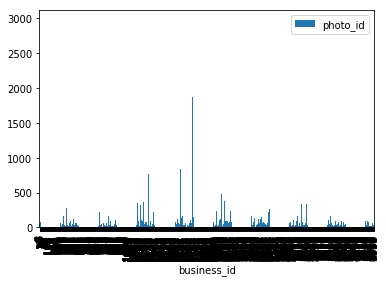

In [68]:
gb = dfbiz.groupby('business_id').agg('count')
gb.plot(kind='bar')

In [128]:
dftrain = pd.read_csv(os.path.join(path, 'train.csv'))
dftrain = pd.merge(dfbizsample, dftrain, on='business_id')
dftrain.head()

,photo_id,business_id,labels
0,204149,3034,3 8
1,172016,3034,3 8
2,253332,3034,3 8
3,225359,3034,3 8
4,107645,3034,3 8


In [129]:
lbls = dftrain["labels"].str.split(' ').apply(pd.Series, 1).stack()
lbls.name = 'split_labels'
lbls.index = lbls.index.droplevel(-1) 
lbls.head()

0    3
0    8
1    3
1    8
2    3
Name: split_labels, dtype: object

In [130]:
del dftrain['labels']
dftrain = dftrain.join(lbls)
dftrain.head()

,photo_id,business_id,split_labels
0,204149,3034,3
0,204149,3034,8
1,172016,3034,3
1,172016,3034,8
2,253332,3034,3


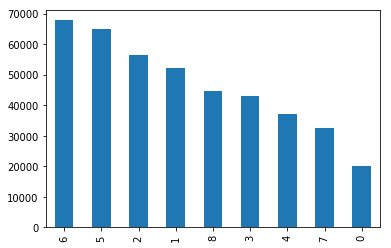

In [131]:
dftrain['split_labels'].value_counts().plot(kind='bar')

In [138]:
# group by label, take a sample for each group
sampleStrataSize = 1000
gb = dftrain.groupby('split_labels')
dfsample = pd.concat([gb.get_group(x).sample(sampleStrataSize) for x in gb.groups])
dfsample.head()

,photo_id,business_id,split_labels
84075,14946,813,1
1850,248435,1773,1
63454,188270,1634,1
71185,120183,2266,1
16472,163884,2086,1


In [211]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(dfsample,  test_size=0.33, random_state=42)

test
train


In [223]:
# setup sample folders
for k,v in {"train": X_train, "test": X_test}.iteritems():
    gb = v.groupby('split_labels')
    for name, x in gb:
        dst = os.path.join(path, k)
        folderName = os.path.join(dst, name)
        if not os.path.exists(folderName):
            os.makedirs(folderName)
        #print(folderName)

In [224]:
# copy image files
import shutil

# setup folders
for k,v in {"train": X_train, "test": X_test}.iteritems():
    gb = v.groupby('split_labels')
    for lbl, x in gb:
        for i, row in x.iterrows():
            name = str(row['photo_id']) + ".jpg"
            src = os.path.join(trainpath, name)
            dst = os.path.join(path, k, lbl, name)
            if not os.path.exists(dst):
                shutil.copy(src, dst)

In [191]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend
backend.set_image_dim_ordering('th')

In [161]:
batchsize = 4
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True
        )
batches = train_datagen.flow_from_directory(
        samplepath,
        target_size=(244, 244),
        shuffle=True,
        batch_size=batchsize)

Found 9000 images belonging to 9 classes.


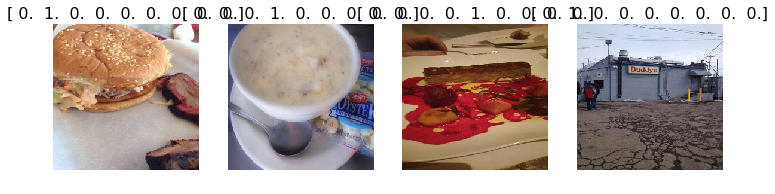

In [162]:
from utils import plots
imgs, labels = next(batches)
plots(imgs, titles=labels)

## Model Creation

In [163]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [165]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

In [166]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [167]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [182]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
print(vgg_mean)

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

[[[ 123.68 ]]

 [[ 116.779]]

 [[ 103.939]]]


In [201]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [202]:
model = VGG_16()
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

C:\Users\rakelkar\AppData\Local\Continuum\anaconda2\lib\site-packages\keras\layers\core.py:630: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
C:\Users\rakelkar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  after removing the cwd from sys.path.
C:\Users\rakelkar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  after removing the cwd from sys.path.
C:\Users\rakelkar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: UserWarning: U

In [226]:
batchsize = 64
train_datagen = ImageDataGenerator()
batches = train_datagen.flow_from_directory(
        os.path.join(path, "train"),
        target_size=(244, 244),
        shuffle=True,
        batch_size=batchsize)

Found 6030 images belonging to 9 classes.


In [227]:
val_datagen = ImageDataGenerator()
val_batches = val_datagen.flow_from_directory(
        os.path.join(path, "test"),
        target_size=(244, 244),
        shuffle=True,
        batch_size=batchsize)

Found 2970 images belonging to 9 classes.


In [206]:
from keras import optimizers
model.pop()

In [207]:
for layer in model.layers: layer.trainable=False
model.add(Dense(batches.num_classes, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [208]:
classes = list(iter(batches.class_indices)) # get a list of all the class labels
print(classes)

['1', '0', '3', '2', '5', '4', '7', '6', '8']


In [210]:
# batches.class_indices is a dict with the class name as key and an index as value
# eg. {'cats': 0, 'dogs': 1}

# sort the class labels by index according to batches.class_indices and update model.classes
for c in batches.class_indices:
    classes[batches.class_indices[c]] = c
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8']


In [229]:
model.fit_generator(batches, samples_per_epoch=batches.samples, nb_epoch=1,
                validation_data=val_batches, nb_val_samples=val_batches.samples)

C:\Users\rakelkar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\rakelkar\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=94, epochs=1, validation_steps=2970)`
  
WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Epoch 1/1


ValueError: Error when checking input: expected lambda_3_input to have shape (None, 3, 224, 224) but got array with shape (64L, 3L, 244L, 244L)